In [159]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)
DEGREE = 50
alphas = [0,.00001,.00005,.0001,.0005,.001,.01,.1,.25,.5,1.,2.,5,10,20,50]

## Re-Regression

In our experience with linear regression, it had a few key characteristics:
<ul>
<li> It relied on a linear relationship between variables. 
<li> It was deterministic (there is one specific solution)
</ul>

#### Polynomial Features and Basis Functions

Basis functions are one way that we can apply linear techniques to non-linear relationships. We can transform the data using what's called a basis function, then do linear regression on that transformed data. The math behind it can be a little beyond what we need, but the idea is pretty simple:

<ul>
<li> The basic linear regression formula is y = w0 + w1*x1 + w2*x2....
<ul>
<li> Where each w is a weight and each x is one of the features. 
</ul>
<li> Applying a basic function transforms those x values to some function of x, such as x^3. So x1 = f1(x), x2 = f2(x).
<ul>
<li> Where each f(x) is some function that transforms that x value - cube, squared, sin, etc...
</ul>
<li> The overall relationship becomes a linear regression of those functions - so we can solve it linearly, but it embraces non-linear relationships. 
</ul>

##### Linear Regression on Polynomial Data

What if we do a linear regression on data that has a cubic function (x^3)?

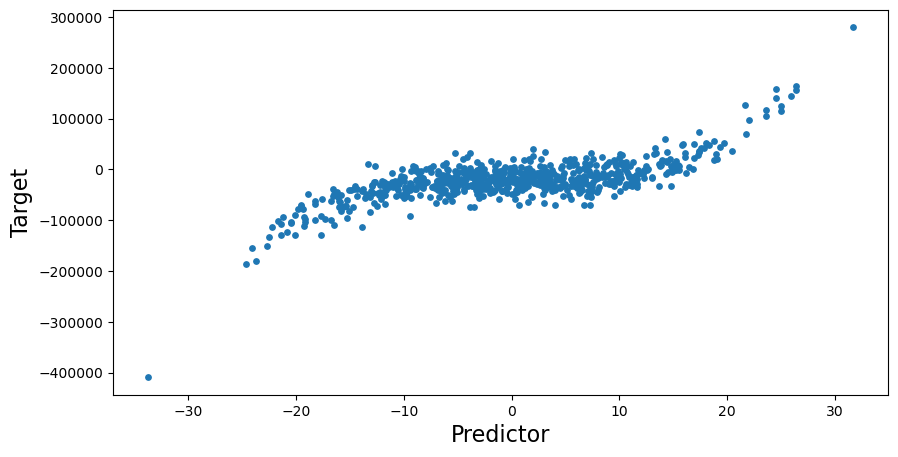

In [160]:
# creating a dataset with curvilinear relationship
x=10*np.random.normal(0,1,700)
y=10*(x**3)+np.random.normal(-20000,20000,700)

# plotting dataset
plt.figure(figsize=(10,5))
plt.scatter(x,y,s=15)
plt.xlabel('Predictor',fontsize=16)
plt.ylabel('Target',fontsize=16)
plt.show()

#### Model With Linear Regression

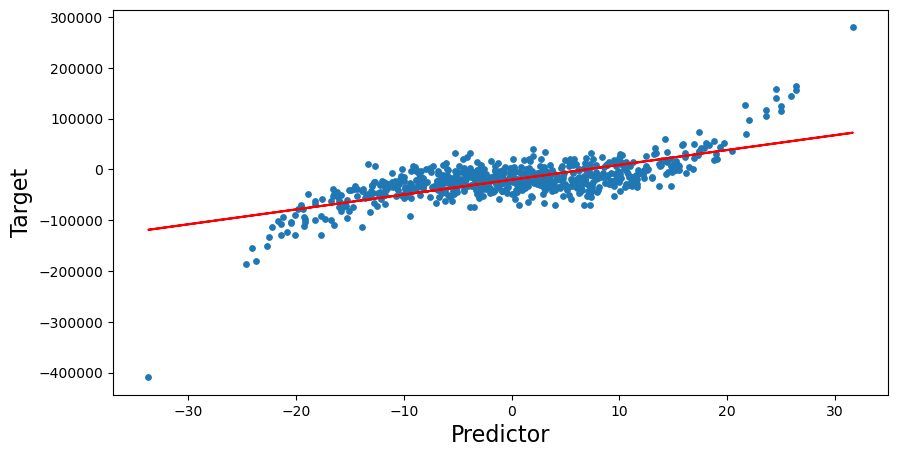

RMSE for Linear Regression=> 29499.637093455403


In [161]:
#Linear Regression Model of Data
lm=LinearRegression()
lm.fit(x.reshape(-1,1),y.reshape(-1,1))

#Plot
y_pred=lm.predict(x.reshape(-1,1))

# plotting predictions
plt.figure(figsize=(10,5))
plt.scatter(x,y,s=15)
plt.plot(x,y_pred,color='r')
plt.xlabel('Predictor',fontsize=16)
plt.ylabel('Target',fontsize=16)
plt.show()
print('RMSE for Linear Regression=>',mean_squared_error(y,y_pred, squared=False))

#### Residual Plot

We can plot the residuals of the model to see if there is a pattern in the errors. If there is a pattern, it suggests that the model is not capturing some underlying pattern in the data. In this case, the patter is pretty clear - the model is not capturing the cubic relationship in the data.

Y-shape: (700,)
Y_pred-shape: (700,)
Residuals-shape: (700,)


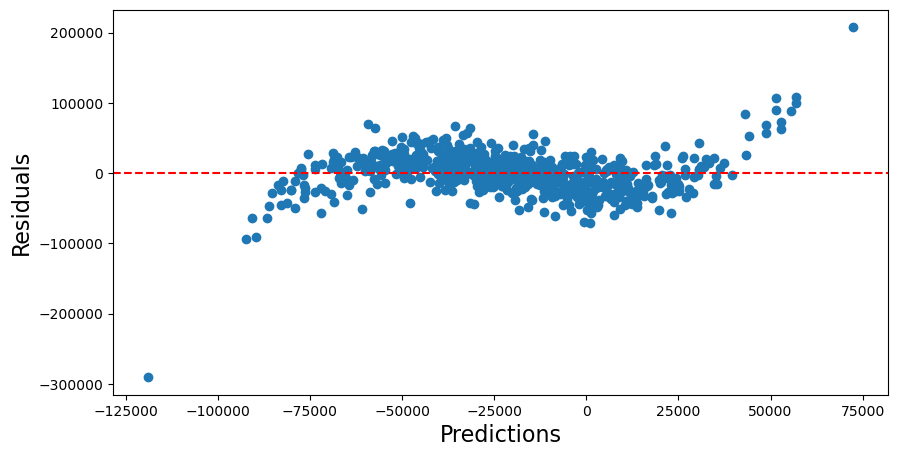

In [162]:
residuals = y - y_pred.flatten()
plt.figure(figsize=(10,5))
print("Y-shape:",y.shape)
print("Y_pred-shape:",y_pred.flatten().shape)
print("Residuals-shape:",residuals.shape)
plt.scatter(y_pred.flatten(),residuals)
plt.xlabel('Predictions',fontsize=16)
plt.ylabel('Residuals',fontsize=16)
plt.axhline(y=0,color='r',linestyle='--')

Not excellent. 

What if we add in a basis function that performs that x^3 transformation?


### Polynomial Features

We can attempt to make a more fitted model by changing from a simple linear regression to a polynomial of higher order - thus allowing our model to curve, and hopefully be a better predictor. 

The pipeline below applies a transformation to the data. Now when the linear regression is making predictions, it is predicting a linear relationship between the set of basis functions. 

In [163]:
model = LinearRegression()
pol_trans = PolynomialFeatures(degree=3)
poly=[('polynomial',pol_trans),('model',model)]
pipe=Pipeline(poly)
pipe.fit(x.reshape(-1,1),y.reshape(-1,1))

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=3)),
                ('model', LinearRegression())])

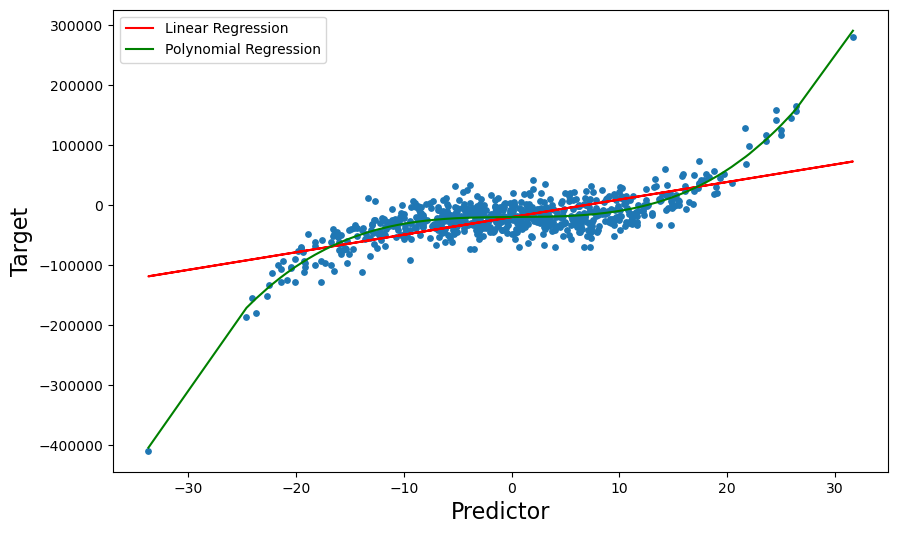

In [164]:
poly_pred=pipe.predict(x.reshape(-1,1))
#sorting predicted values with respect to predictor
sorted_zip = sorted(zip(x,poly_pred))
x_poly, poly_pred = zip(*sorted_zip)
#plotting predictions
plt.figure(figsize=(10,6))
plt.scatter(x,y,s=15)
plt.plot(x,y_pred,color='r',label='Linear Regression')
plt.plot(x_poly,poly_pred,color='g',label='Polynomial Regression')
plt.xlabel('Predictor',fontsize=16)
plt.ylabel('Target',fontsize=16)
plt.legend()
plt.show()

In [165]:
# Assuming you have already fitted the polynomial regression model
coefficients = pipe.named_steps['model'].coef_
intercept = pipe.named_steps['model'].intercept_

# Print the equation of the polynomial regression line
equation = "y = "
for i, coef in enumerate(coefficients[0]):
    equation += f"({coef:.2f} * x^{i}) + "
equation += f"({intercept[0]:.2f})"
print(equation)


y = (0.00 * x^0) + (92.66 * x^1) + (-4.47 * x^2) + (9.82 * x^3) + (-20164.55)


#### That's more like it!

What happened? The polynomial functions thing is a transformer that does a transformation on our data, in this case to the power of 3 - cubing. This allows us to use our regular ol' linear regression to handle more complex relationships. 

#### Polynomial Functions

Polynomial functions is a common transformer but that transformation could be anything - the idea stays the same. 

#### Residual Plots 

We can compare the residual plots of the two models to see how well they fit the data. Note that the polynomial model has a much smaller residual plot - indicating that it is a better fit. More substantially, there's not a pattern in the residuals, indicating that the model is not missing out on some key relationship.

Y shape: (700,)
Poly_pred shape: (700, 1)


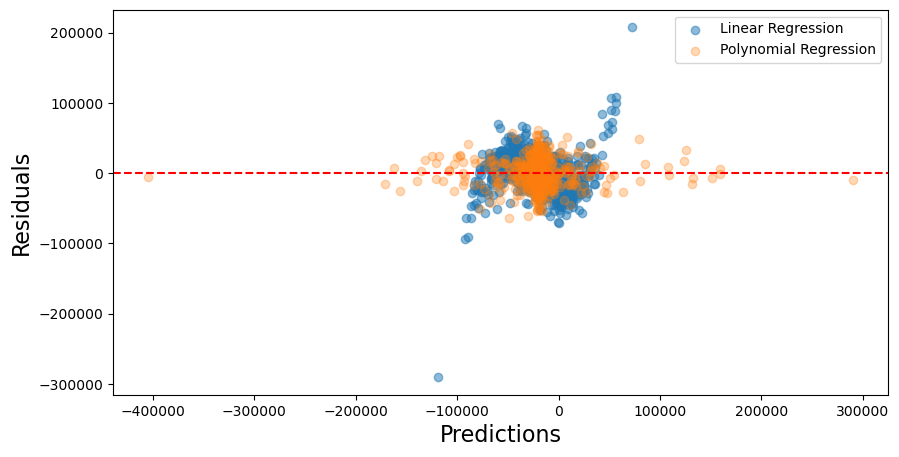

In [166]:
preds = pipe.predict(x.reshape(-1,1))
residuals_poly = y - preds.flatten()
print("Y shape:",y.shape)
print("Poly_pred shape:",preds.shape)
plt.figure(figsize=(10,5))
plt.scatter(y_pred.flatten(),residuals, alpha=0.5)
plt.scatter(preds,residuals_poly, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predictions',fontsize=16)
plt.ylabel('Residuals',fontsize=16)
#add legend
plt.legend(['Linear Regression','Polynomial Regression'])
plt.show()

## Types of Error in ML

An important theoretical result of statistics and Machine Learning is the fact that a model’s generalization error can be expressed as the sum of three very different errors:

### Bias

This part of the generalization error is due to wrong assumptions, or not "tailoring" the model to fit the data enough - such as assuming that the data is linear when it is actually quadratic, in this case. A high-bias model is most likely to underfit the training data. Model with high bias pays very little attention to the training data and oversimplifies the model.

### Variance

This part is due to the model’s excessive sensitivity to small variations in the training data, or tailoring to fit the data too much. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data. Models with high variance pay a lot of attention to training data and does not generalize well on the data which it hasn’t seen before. As a result, such models perform very well on training data but has high error rates on test data.

### Irreducible error

This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).

### Bias-Variance Trade Off

![Error Calculations](images/error_bias_var.png "Error Calculations" )

Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. We are aiming for models that have enough variance that they are tailored to the data, but have enough bias that they are generally applicable. Our optimal accuracy will come at the point where they are in balance:

![Bias and Variance](images/bias_var_curve.png "Bias and Variance" )

When selecting a model we need to balance these concerns to make a suitable and reliable choice. We want a model with enough variance, or enough capacity to tailor itself to the training data, to capture the complexity of our scenario adequately. We also want to make sure that we have enough bias, or resistance to being changed by specifics in the training data, to create a model that is generalizable - or will produce good predictions for data our model has not seen before. 

Overall, we can generally make more complex models, or those with more variance and ability to overfit, as we have more data to train on. If we have a model with a large amount of variance, we will probably overfit if the amount of training data is small; if we have large amounts of data, that ability of the model to tailor itself to the data will be beneficial if we have many examples to feed it. If we have a small amount of training data, we lack the amount of data needed to "teach" a high-variance model well, so we can't trust our predictions to be as generalizable. 

### Errors in the Cubic Function Above

##### High Bias and Underfitted

The first linear model is underfitted - it obviously isn't all that close of a match to the data, though it roughly approximates it. 

##### High Variance and Low Bias

The new model is much more fitted to the data. The varaince is higher. In this case it is a pretty accurate match. 

### Regression with a Crazy Function

What if we have some shape that is more complex? We can still use the basis functions to model it linearly, and we can use the grid search to look for the appropriate power of the polynomial. (Though here I've broken it out more to be illustrative)

First, make some fancy data with curves...

<b>Note:</b> I have a step in there to filter some data from the ends. The reason for this is that the data will, by default, have some noise at the ends. Removing that makes a better example for what we are looking at as the fitting of the transformed models makes more of an impact. You can scale back or remove it, and see the difference - in most cases it ends up making the lower order polynomials look better. 

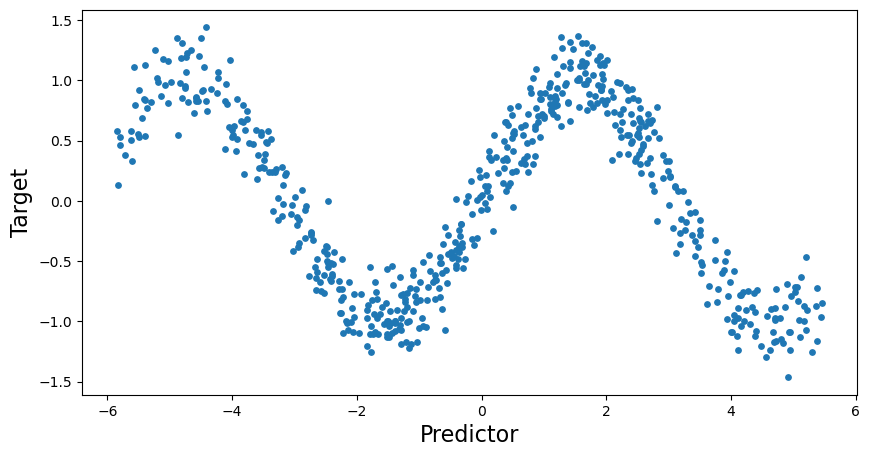

(420, 420)

In [167]:
# Generate and plot data set. 
x = 4*np.random.normal(0,1,700)
y = np.sin(x) + 0.2 * np.random.randn(700)
#y = np.sin(x) + 0.1 * np.random.randn(700)
# plotting dataset
#sort x and y
sorted_zip = sorted(zip(x,y))
x, y = zip(*sorted_zip)
# Filter Ends
filter_amount = 50
x = np.array(x[filter_amount:700-filter_amount])
y = np.array(y[filter_amount:700-filter_amount])

plt.figure(figsize=(10,5))
plt.scatter(x,y,s=15)
plt.xlabel('Predictor',fontsize=16)
plt.ylabel('Target',fontsize=16)
plt.show()

x, x_te, y, y_te = train_test_split(x, y, test_size=0.3, random_state=42)
x.size, y.size

Now we can try to fit different linear regressions, with different bias functions to the data. We'll use a grid search to test a bunch of different transformations, look at the errors, and plot the curves. Try playing with the 'degrees' list to see some different fits. 

Test RMSE 1 0.7308096077331784
Test RMSE 2 0.730794653300136
Test RMSE 3 0.5754702791064554
Test RMSE 4 0.5673001338942669
Test RMSE 5 0.24406335497066975
Test RMSE 6 0.23827733427793338
Test RMSE 7 0.20697312834964682
Test RMSE 8 0.20565465696403093
Test RMSE 9 0.20641106032316092
Test RMSE 10 0.2076284397030888
Test RMSE 11 0.20820770755401385
Test RMSE 12 0.20861717245646627
Test RMSE 13 0.20858033130062484
Test RMSE 14 0.2089850133343075


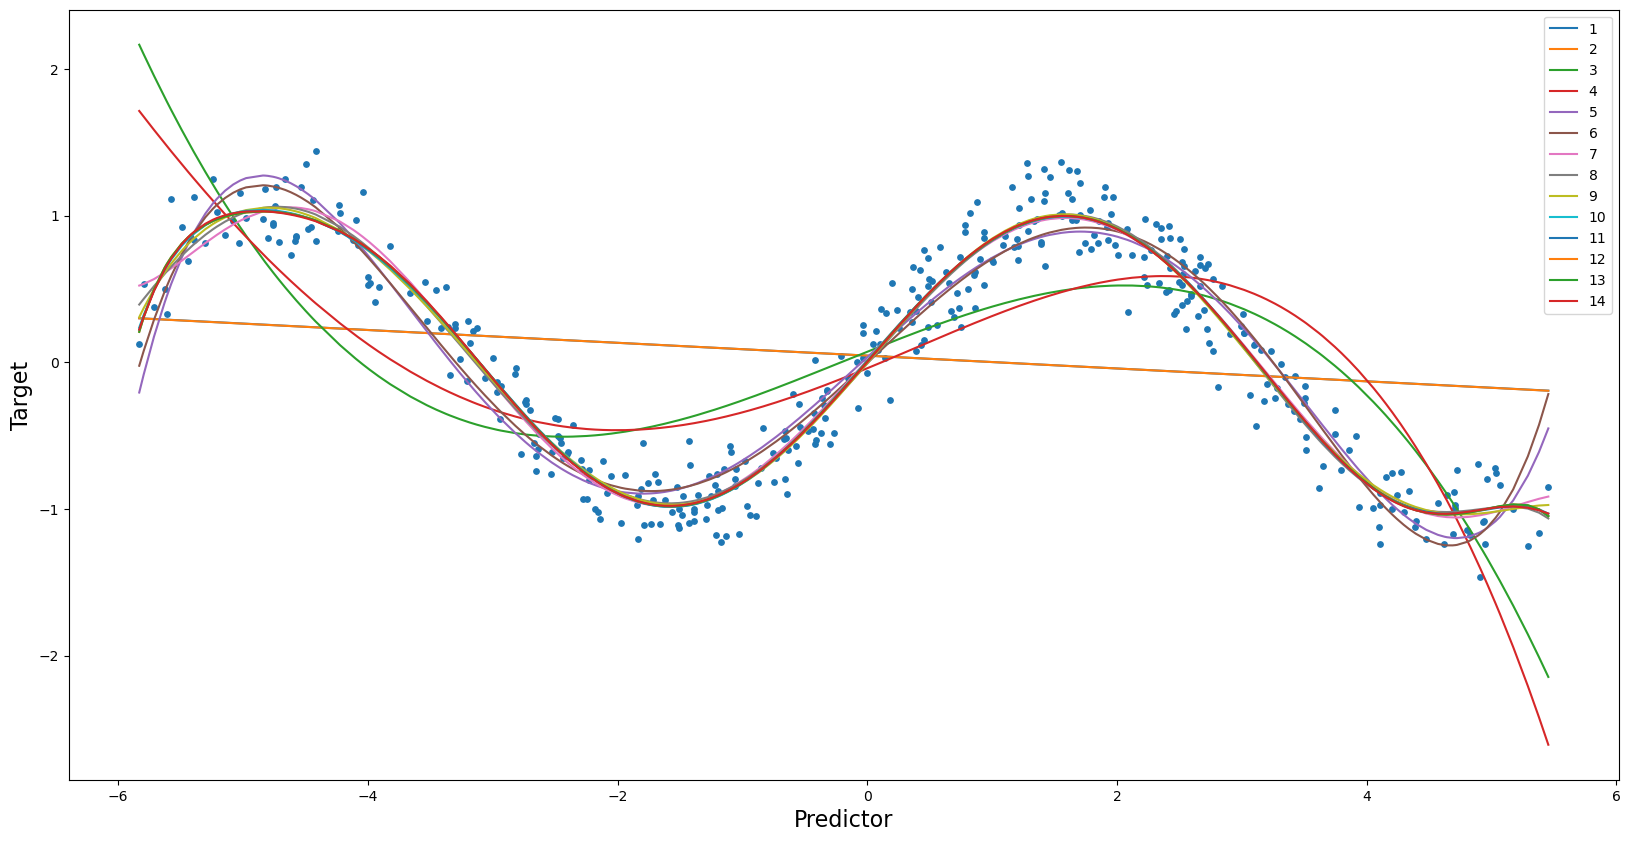

In [168]:
poly=[('polynomial',PolynomialFeatures()),('model',LinearRegression())]
pipe=Pipeline(poly)

degrees = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
#degrees = [2,3,4,5,10,11,12,13,14,15,20,35,100,200]
params = {'polynomial__degree':degrees}
 
reg = GridSearchCV(pipe, param_grid=params, cv=3) 
reg.fit(x.reshape(-1,1),y.reshape(-1,1))

plt.figure(figsize=(20,10))
plt.scatter(x,y,s=15)
plt.xlabel('Predictor',fontsize=16)
plt.ylabel('Target',fontsize=16)

for deg in degrees:
    poly=[('scaler', StandardScaler()), ('polynomial',PolynomialFeatures(degree=deg)),('model',LinearRegression())]
    pipe = Pipeline(poly)
    pipe.fit(x.reshape(-1,1),y.reshape(-1,1))
    poly_pred = pipe.predict(x.reshape(-1,1))
    #sorting predicted values with respect to predictor
    sorted_zip = sorted(zip(x,poly_pred))
    x_poly, poly_pred = zip(*sorted_zip)
    #plotting predictions
    plt.plot(x_poly,poly_pred,label=deg)
    #print('Train RMSE', deg,mean_squared_error(y,poly_pred, squared=False))
    print('Test RMSE', deg,mean_squared_error(y_te,pipe.predict(x_te.reshape(-1,1)), squared=False))
plt.legend()
plt.show()


### Bias and Variance Above

There are a whole bunch of models with a whole bunch of different fits. The details will vary due to randomness, for most of my trials a degree of about 4 or 5 gives the best overall choice. Often the very high degree polynomials give slightly better error metrics, but we are adding variance to make those models, likely overfitting our data. 

<b>High Bias</b> - The low degree models are underfitting the data. They are not "learning" from the data all that much, and don't capture the up and down swings enough.
<b>High Variance</b> - The high degree models are overfitting the data. They become volitile attempting to follow the swings in the data, and likely don't generalize well to new data.

## Linear Regression and Regularization

Linear regression works by building a model that assigns a coefficient to each of the terms, eg y = a1*x1 + a2*b2 + a3*x3 + b. These coefficients determine the relative importance of different features to the end result of the models. We also saw that it was pretty common for us to be able to create a model that was very close to as accurate after having removed some of the least important features - those with large p values. 

When dealing with datasets with large number of features, this problem can be amplified - the potential for overfitting is there because we have many, many features that have a slight impact to the final prediction. 

### Regularization

Regularization is a method for constraining the complexity of a linear regression model by limiting the coefficients. It functions by adding a penalty term to the cost function while training, this causes the algorithm to seek to minimize the weights when creating the model. We are effectively discouraging the model from being more complex - from incorporating a large number of features. 

Note: Scaling values is important when doing regularization. 

#### Ridge Regression - L2

Ridge regression adds a term to the cost function equal to the square of the magnitude of the coefficients. We can see from the example below, the higher that the alpha value, which defines the penalty amount, goes, the less varaiance the model is allowed to have. We are constraining it. An alpha of 0 makes the penalty term 0, and is just normal linear regression. As the alpha increases, the model becomes more and more constrained by the penalty term. The greater the impact of the penalty term, the more the model will be forced to reduce the coefficients, and the more that factor will be weighted against the "original" cost function.

![L2 Regularization](images/l2_reg.jpeg "L2 Regularization" )

In [169]:
import warnings
warnings.filterwarnings("ignore")

##### Try With Several Alphas

Above, I supressed warnings. This is because I made this before a library was updated, so I don't want warnings that things will break in the future. 

Below we should see the models with a higher alpha value display more bias and less variance - they are being limited in their ability to fit the data, thus leaving less volitile models. 

(294,) (126,) (294,) (126,)
0 0.05220588683804834
1e-05 0.052203211048696435
5e-05 0.052208427432911465
0.0001 0.0522049421373241
0.0005 0.05220615690884498
0.001 0.05220707497194457
0.01 0.052205495031533995
0.1 0.05220507495949089
0.25 0.052200643142014856
0.5 0.05220168986398462
1.0 0.0521946890146888
2.0 0.052190952417010585
5 0.05218592815649851
10 0.05218432365858541
20 0.052185567672152725
50 0.05218797526761571


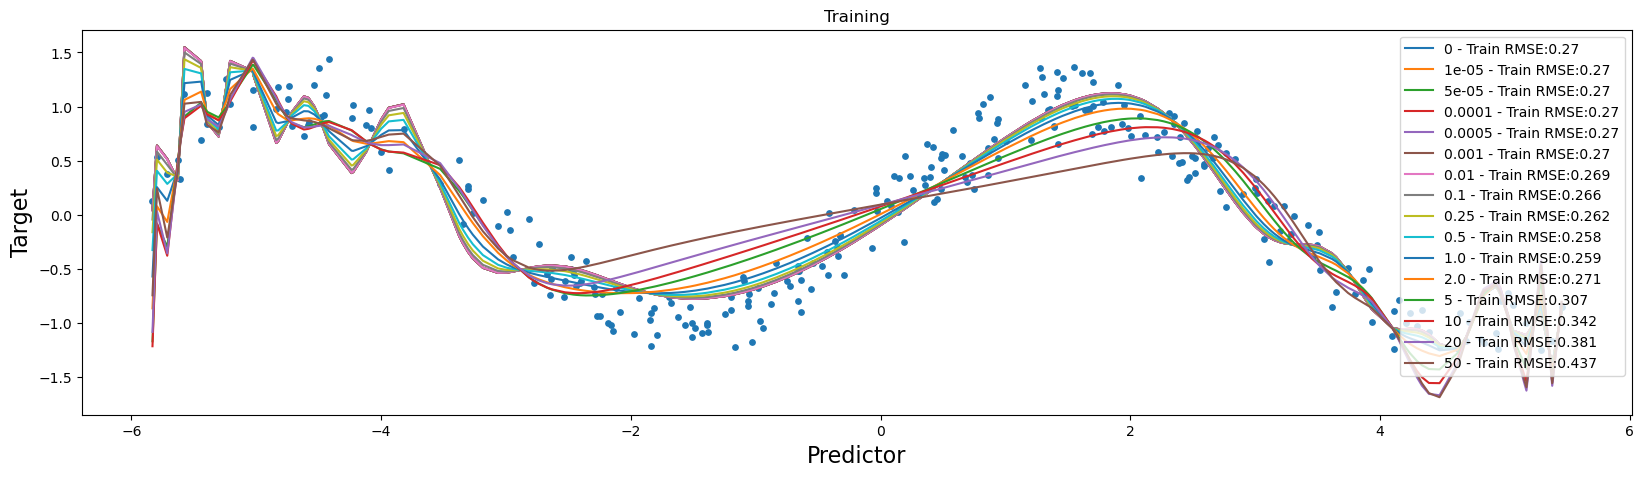

In [170]:
#Ridge Example

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

plt.figure(figsize=(20,5))
plt.scatter(X_train,y_train,s=15)
plt.title("Training")
plt.xlabel('Predictor',fontsize=16)
plt.ylabel('Target',fontsize=16)

test_preds = []
l2_models = []
train_preds_stack = []
#scaler = StandardScaler()
trans = PolynomialFeatures(DEGREE)

for a in alphas:
    model = Ridge(alpha=a)
    #model = Lasso(alpha=a, selection='random')
    pipeline = Pipeline(steps=[('s', StandardScaler()), ('t', trans), ('m', model)])
    trans_fit = pipeline.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
    l2_models.append(model)
    #tmp_data = X_train.reshape(-1,1)
    train_preds = trans_fit.predict(X_train.reshape(-1,1))
    #print(train_preds)
    d_ridge = pd.DataFrame(X_train, columns=["X"])
    d_ridge["y_Ridge"] = train_preds
    label = str(a)+" - Train RMSE:"+str(round(mean_squared_error(train_preds,y_train, squared=False),3))
    #label = str(a)+" - Test RMSE:"+str(round(mean_squared_error(trans_fit.predict(X_test.reshape(-1,1)),y_test, squared=False),3))
    sns.lineplot(data=d_ridge, x="X", y="y_Ridge", label=label)
    #d_ridge.head()
    test_preds.append(trans_fit.predict(X_test.reshape(-1,1)))
    train_preds_stack.append(trans_fit.predict(X_train.reshape(-1,1)))
    print(a, np.mean(train_preds))


#### Plotting Test Data and Results

We can plot the models for the test predictions as well.

For mine, not every time due to randomness, but often, the model with an alpha of 0 had extreme errors. This is an example of excessive varaiance. The model was too well suited to the specific data it saw in training, and when faced with test data, it ended up being awful. Adding some constraints on that variance, in this case normally very little, helps make a better model. 

We can also see the RMSE values flattening as the alpha increases - we are making our model more and more general, eventually there isn't really any more change, it is totally generic. That's why those models are overlapping straight(ish) lines, they are barely customized to the data at all. 

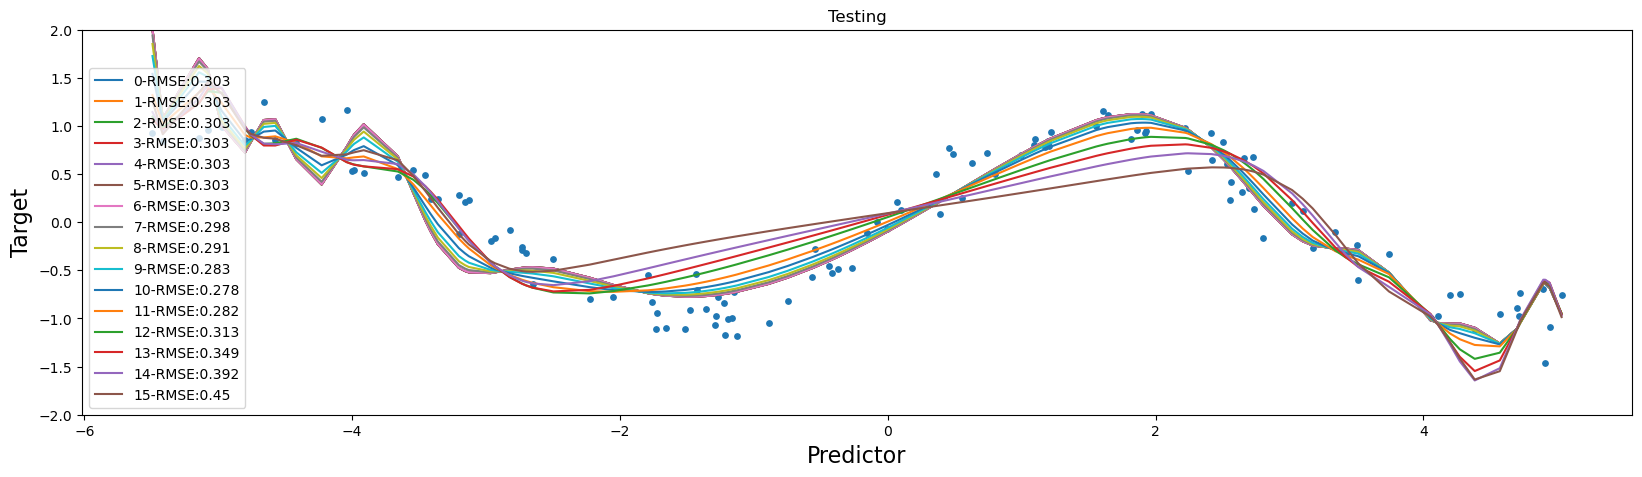

In [171]:
plt.figure(figsize=(20,5))
plt.scatter(X_test,y_test, s=15)
plt.ylim(-2,2)
plt.title("Testing")
plt.xlabel('Predictor',fontsize=16)
plt.ylabel('Target',fontsize=16)

for p in range(len(test_preds)):
    d_ridge = pd.DataFrame(X_test, columns=["X"])
    d_ridge["y_Ridge"] = test_preds[p]
    label = str(p)+"-RMSE:"+str(round(mean_squared_error(test_preds[p],y_test, squared=False),3))
    sns.lineplot(data=d_ridge, x="X", y="y_Ridge", label=label)

#### Coefficient Results

We can plot or examine the coefficients of the models as well. The first line of the code below controls which model is being examined, they are placed into a list in order. The argument of -1 gets the last of the models in the list, the one with the highest alpha. We should expect that the coefficients of the model should drop as we impose more and more cost on the regularization term of the cost function.

            coef
count  51.000000
mean    0.006331
std     0.087033
min    -0.070271
25%    -0.012714
50%    -0.000851
75%     0.007684
max     0.583364


<Axes: xlabel='coef', ylabel='Count'>

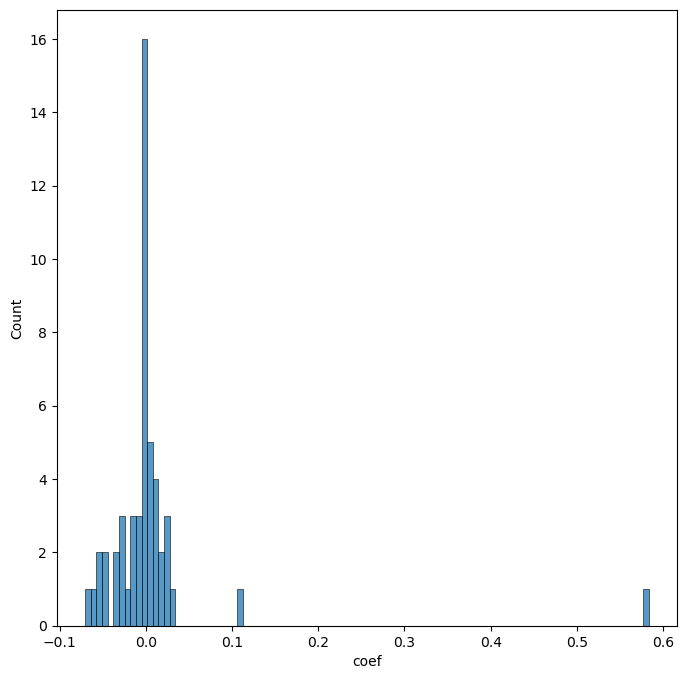

In [172]:
coefs = l2_models[-1].coef_.T
df_coef = pd.DataFrame(coefs, columns=["coef"])
print(df_coef.describe())
#sns.histplot(df_coef, x="coef",binrange=(-.0000000000000000000000000000000000001,.0000000000000000000000000000000000001),bins=50)
sns.histplot(df_coef, x="coef",binrange=(np.min(coefs),np.max(coefs)),bins=100)

#### Coefficient Sizes

We can look at the average values of the coefficients that are generated by each of the models. Since large coefficients are penalized more, we should expect that the average size of the coefficients will decrease as the alpha increases. It isn't perfect or (necessarily) linear, but as alpha increases, the average size of the coefficients should decrease.

In [173]:
for coefs in l2_models:
    print("Alpha: " + str(coefs.alpha) + " Avg. Coefs: " + str(np.mean(np.abs(coefs.coef_))))

Alpha: 0 Avg. Coefs: 0.2369803051636501
Alpha: 1e-05 Avg. Coefs: 0.23697917614501735
Alpha: 5e-05 Avg. Coefs: 0.23697466017791863
Alpha: 0.0001 Avg. Coefs: 0.2369690154607563
Alpha: 0.0005 Avg. Coefs: 0.23692386738959348
Alpha: 0.001 Avg. Coefs: 0.23686745645479101
Alpha: 0.01 Avg. Coefs: 0.23585662687582193
Alpha: 0.1 Avg. Coefs: 0.22627170112121617
Alpha: 0.25 Avg. Coefs: 0.21195168752935664
Alpha: 0.5 Avg. Coefs: 0.1918655904088856
Alpha: 1.0 Avg. Coefs: 0.16180681063972757
Alpha: 2.0 Avg. Coefs: 0.12456339928299771
Alpha: 5 Avg. Coefs: 0.08433450177684078
Alpha: 10 Avg. Coefs: 0.0653046731688418
Alpha: 20 Avg. Coefs: 0.0488045336052375
Alpha: 50 Avg. Coefs: 0.029204293558124376


### Lasso Regression

Lasso regression also adds a penalty term to the cost function, this one is based on the absolute value of the magnitude of the cost function. 

![L1 Regularization](images/l1_reg.jpeg "L1 Regularization" )

The process inside of the lasso regression is similar to the ridge regression, but the penalty term is different. The lasso regression will actually set some of the coefficients to 0, effectively removing them from the model. This is a form of feature selection that we can get "for free" by using the lasso regression. As well, since absolute value calculations are not differentiable, the lasso regression is not differentiable, and thus cannot be solved with normal gradient descent; the estimating to work with the absolute values will slow the process. 

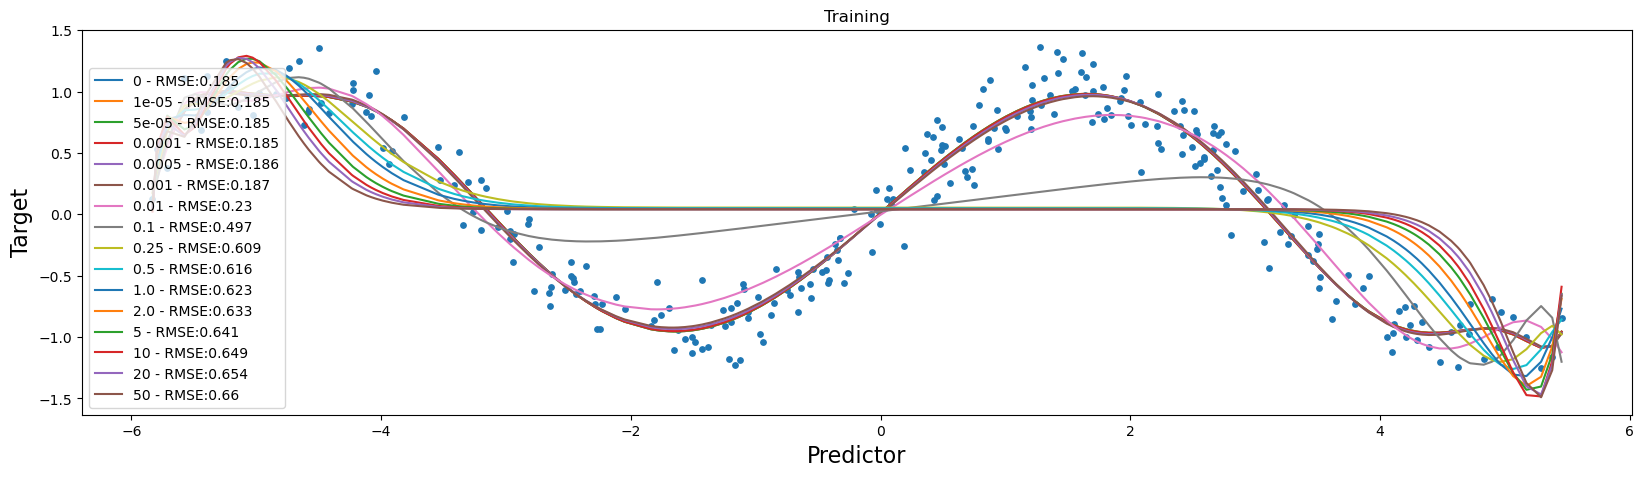

In [174]:
#Lasso Example
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.3)
plt.figure(figsize=(20,5))
plt.scatter(X_train,y_train,s=15)
plt.title("Training")
plt.xlabel('Predictor',fontsize=16)
plt.ylabel('Target',fontsize=16)

test_preds = []
l1_models = []
scaler = StandardScaler()
trans = PolynomialFeatures(DEGREE)

for a in alphas:
    model = Lasso(alpha=a, selection="random", max_iter=10000)
    pipeline = Pipeline(steps=[('s', scaler), ('t', trans), ('m', model)])
    trans_fit = pipeline.fit(X_train.reshape(-1,1),y_train.reshape(-1,1))
    l1_models.append(model)
    train_preds = trans_fit.predict(X_train.reshape(-1,1))
    d_ridge = pd.DataFrame(X_train, columns=["X"])
    d_ridge["y_Ridge"] = train_preds
    label = str(a)+" - RMSE:"+str(round(mean_squared_error(train_preds,y_train, squared=False),3))
    sns.lineplot(data=d_ridge, x="X", y="y_Ridge", label=label)
    test_preds.append(trans_fit.predict(X_test.reshape(-1,1)))

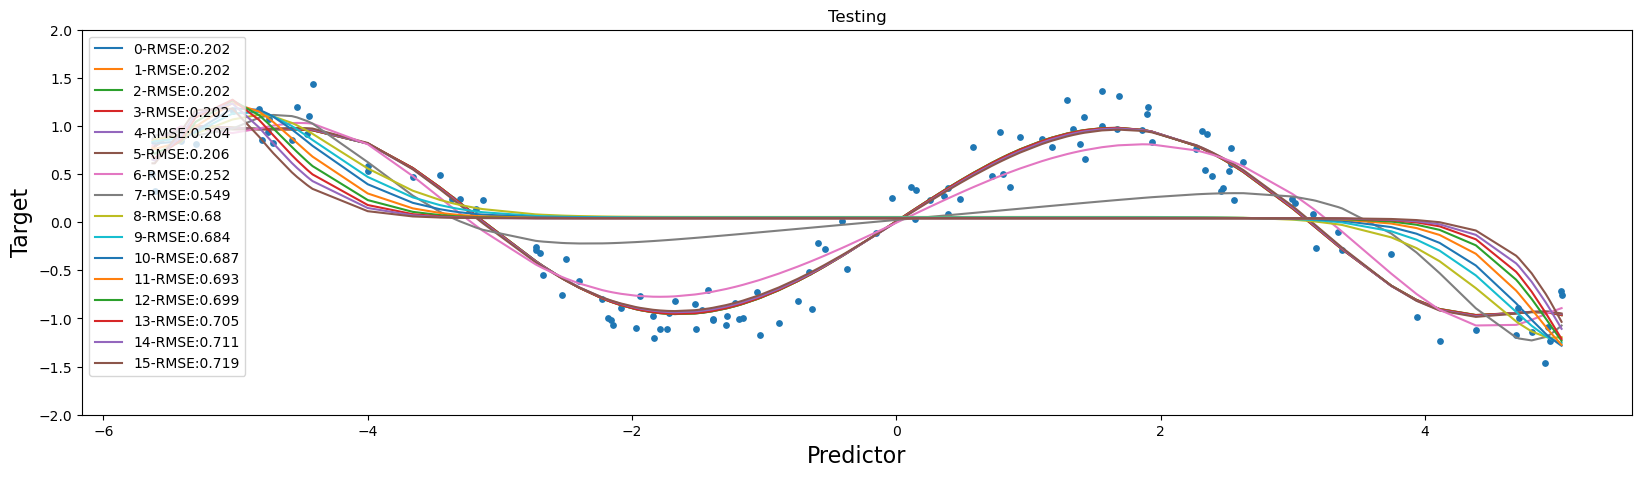

In [175]:
plt.figure(figsize=(20,5))
plt.scatter(X_test,y_test, s=15)
plt.ylim(-2,2)
plt.title("Testing")
plt.xlabel('Predictor',fontsize=16)
plt.ylabel('Target',fontsize=16)

for p in range(len(test_preds)):
    d_ridge = pd.DataFrame(X_test, columns=["X"])
    d_ridge["y_Ridge"] = test_preds[p]
    label = str(p)+"-RMSE:"+str(round(mean_squared_error(test_preds[p],y_test, squared=False),3))
    sns.lineplot(data=d_ridge, x="X", y="y_Ridge", label=label)

#### Coefficient Results

Just like with the ridge results above, we can plot or examine the coefficients of the models as well. One thing to look at here is that the higher alpha models likely have coefficients that have been reduced down to 0. If we look at the RMSE values, I'd bet that once the RMSE values start to be the same, we'll probably see the set of coefficients that are largely 0. The lasso regression has selected out these features as less important, as opposed to the Ridge regression which just limited the coefficients. Note that we also probably have some that are very close to 0. 

               coef
count  5.100000e+01
mean  -2.621340e-06
std    1.659389e-05
min   -1.180704e-04
25%   -4.793650e-16
50%    0.000000e+00
75%    5.608037e-12
max    1.085949e-06
Number of Coefficients that are 0: 18


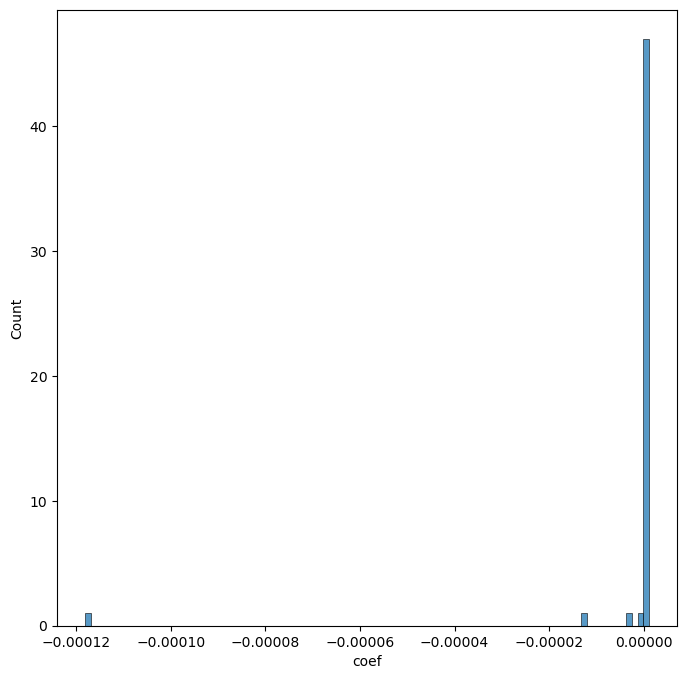

In [176]:
coefs = l1_models[-1].coef_.T
df_coef = pd.DataFrame(coefs, columns=["coef"])
print(df_coef.describe())
#sns.histplot(df_coef, x="coef",binrange=(-.0000000000000000000000000000000000001,.0000000000000000000000000000000000001),bins=50)
sns.histplot(df_coef, x="coef",binrange=(np.min(coefs),np.max(coefs)),bins=100)
print("Number of Coefficients that are 0: " + str(len(coefs[coefs==0])))

#### Coefficient Sizes

We can look at the average values of the coefficients here as well. Since large coefficients are penalized more, we should expect that the average size of the coefficients will decrease as the alpha increases.

In [177]:
for coefs in l1_models:
    print("Alpha: " + str(coefs.alpha) + " Avg. Coefs: " + str(np.mean(np.abs(coefs.coef_))))

Alpha: 0 Avg. Coefs: 0.12803599733268375
Alpha: 1e-05 Avg. Coefs: 0.12802691787492834
Alpha: 5e-05 Avg. Coefs: 0.12810798374561932
Alpha: 0.0001 Avg. Coefs: 0.12593494056979385
Alpha: 0.0005 Avg. Coefs: 0.11985162358500216
Alpha: 0.001 Avg. Coefs: 0.1134744423365853
Alpha: 0.01 Avg. Coefs: 0.0704743739831053
Alpha: 0.1 Avg. Coefs: 0.009655666838643223
Alpha: 0.25 Avg. Coefs: 0.0005737322808959249
Alpha: 0.5 Avg. Coefs: 0.0003130339242294758
Alpha: 1.0 Avg. Coefs: 0.00015516600871113556
Alpha: 2.0 Avg. Coefs: 6.798504619050327e-05
Alpha: 5 Avg. Coefs: 2.9643862598338753e-05
Alpha: 10 Avg. Coefs: 1.1890135480830439e-05
Alpha: 20 Avg. Coefs: 7.052633867041425e-06
Alpha: 50 Avg. Coefs: 2.678294705115676e-06


### Regularization

Both of these regularization techniques do the same thing in a similar way - they penalize having larger weights, thereby incentivizing models that are more stable. Some important differences are:

<ul>
<li> L1 can encourage weights to go to 0, so it can write out some variables entirely. 
<li> L1's absolute value makes the cost function is non-differentiable - meaning that you can't take the derivitive for gradients. So the algorithm needs to simulate that, which is slower. This is a major reason that we see L2 more commonly, especially in neural networks, as the performance difference can add up when it is calculated millions of times. 
</ul>

#### Picturing Regularization

Regularization impacts can be visualized by an image similar to the one below. Think of this as being the calculation for one feature. Instead of reaching a weight that is "optimal" (the middle of the rings) as you would using standard least squared regression, regularization needs to balance that amount of error (the rings) with the penalty term (the circle/diamond). So the finalized weights is where these two intersect - where the "real" error and the penalty error are in balance:

![Regularization](images/regularization_rings.jpeg "Regularization" )

## Exercise - Car Price Redux

We can revisit the car price regression and try with one or both of the regularized models. We aren't totally sure if we'll see better results, there is hope that we will! Because regularization will minimize the less significant features, we should be able to better deal with that multicollinearity. The L1 model should also help us if we want to find some information for feature selection. 

For this one we have both numeric and categorical data, so we'll need to do some preprocessing. A column transformer is a great choice here... 

In [178]:
df3 = pd.read_csv("data/CarPrice_Assignment.csv")
df3.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [179]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score

numeric_features = ["wheelbase", "carlength", "carwidth", "carheight", "curbweight", "enginesize", "boreratio", "stroke", "compressionratio", "horsepower", "peakrpm", "citympg", "highwaympg"]
numeric_transformer = Pipeline( steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", MinMaxScaler())
    ])

categorical_features = ["symboling", "fueltype", "aspiration", "doornumber", "carbody", "drivewheel", "enginelocation", "enginetype", "cylindernumber", "fuelsystem"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer( remainder='drop',
        transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ])

#Split data as normal
y3 = df3["price"]
X3 = df3.drop(columns={"price"})

#Build pipeline
l1_model = Lasso(alpha=0.2)
l2_model = Ridge(alpha=0.2)
pipeline_steps = [('pre', preprocessor),('model', l1_model) ]
pipe = Pipeline(pipeline_steps)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3)
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set

pipe.fit(X_train3, y_train3)
cvs = cross_val_score(pipe, X_train3, y_train3.ravel(), cv=5)
print('Training CrossVal Score:', cvs)
print("Average Train Score:", np.mean(cvs))
print('Testing score:', pipe.score(X_test3, y_test3))

Training CrossVal Score: [0.72716309 0.8706261  0.79080589 0.83705548 0.93111376]
Average Train Score: 0.8313528646596703
Testing score: 0.8365472952297734


We can extract the coefficients for the model, L1 in particular. We can see there are probably a few features that have been set with a weight of 0. This can be helpful for feature selection, which we'll do a bit more on after the regression stuff in a week or so. 

In [180]:
l1_model.coef_

array([-1.30904799e+03, -3.14154194e+03,  7.09079494e+03,  1.70443834e+03,
        1.34480296e+04,  4.62653081e+04, -1.08340327e+04, -1.08731041e+04,
        1.29142187e+03,  4.63382667e+03,  4.31607486e+03, -7.52114213e+03,
        8.47772074e+03, -2.62417033e+03,  2.99003142e+02,  7.35096441e+02,
        4.17919998e+02, -5.86229388e+02, -1.22320921e+01,  2.80146663e+02,
       -6.87471256e-11, -1.70498282e+03,  3.48221452e-13, -7.31863281e+02,
        1.98743399e-12,  2.07168434e+03, -1.26486093e+03, -0.00000000e+00,
        8.72264668e+02, -5.38393741e+02, -7.42719754e+02,  0.00000000e+00,
        7.65394077e+02, -6.84849122e+03,  1.16830279e-11, -2.24785336e+03,
       -4.44670472e+03, -7.38181325e+02,  2.62694468e+03,  2.34207590e+03,
       -7.17590695e+03,  1.01027303e+04,  1.35982121e+03, -1.22731134e+02,
        1.77304011e+03, -4.25957136e+02, -1.78191323e+04,  1.91365860e+03,
       -1.65350354e+00,  1.69144874e+02,  2.84187359e+02,  0.00000000e+00,
       -2.95249515e+03,  

<Axes: ylabel='Count'>

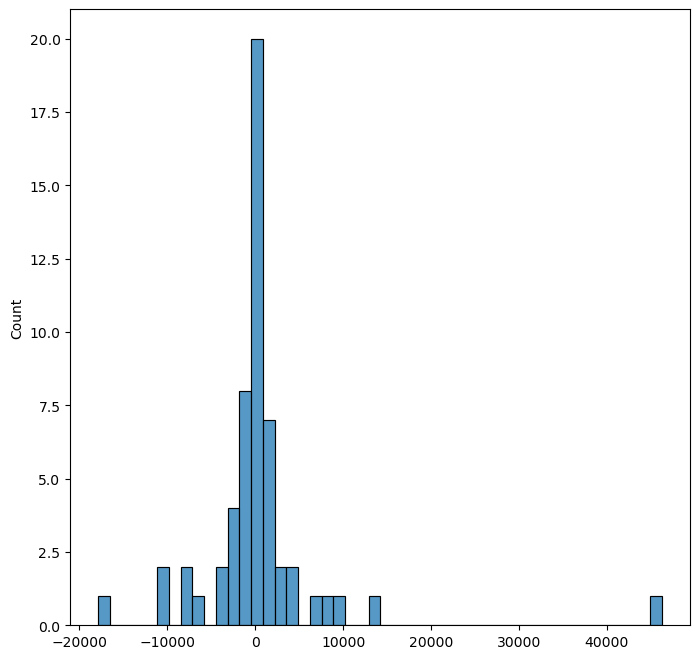

In [181]:
sns.histplot(l1_model.coef_)

## Elastic Net

The third type of regularization is called Elastic Net, and it is just a blend of L1 and L2. We can implement this in the same way as the Ridge/Lasso, one thing that we can set is the blend between L1 and L2 - controlled by a HP called "l1_ratio", which is simply what percentage of the penalty term is L1 vs L2. In this example use a grid search to find the best. 

![Elastic Net](images/elastic_net.png "Elastic Net" )

This is basically a compromise between the two types of regularization seen above, as it is just a weighted average of the two penalty terms.

![EN Error](images/el_error.png "EN Error" )

### Selecting Regularization Types

All of these regularization methods do, broadly, the same thing. They penalize the cost function for having large weights, and thus encourage the model to be more stable. This will generally limit the overfitting of the model, and thus improve the performance on test data. Regularization can be used to this effect wherever gradient descent is used - most notably in neural networks that we'll look at later. Each type of regularization has its own benefits and drawbacks, and we can use that information, in combination with a good old fashioned grid search, to find the best model for our data.
<ul>
<li> <b>L1 Regularization:</b>
    <ul>
    <li> Allows for feature selection, as it can set some coefficients to 0.
    <li> Computationally slower. 
    <li> Selecting out features can be helpful for interpretability.
    <li> Can yeild a sparse model (mostly 0s). (We'll talk more about this with neural networks)
    </ul>
<li> <b>L2 Regularization:</b>
    <ul>
    <li> Reduces impact of the less important features, without removing them.
    <li> Computationally quick since it is differentiable.
    <li> Yeilds a dense model, which is what we are used to. 
    </ul>
<li> <b>Elastic Net Regularization:</b>
    <ul>
    <li> Algebraic blend of the previous two.
    <li> Computationally slower than either. 
    <li> Can be used in a grid search to find the best choice of the above two, or the optimal blend.
    </ul>
</ul>

In general, we want to use L2 as it is the quickest, unless there's some reason not to. This could be the desire to perform feature selection or because we've tested a more accurate chocie for our data. 

#### Example - Elastic Net

Predict the car price from data above using elastic net. Use a grid search to find the best blend of L1 and L2 regularization.

In [182]:
#Preview data again
df3.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [183]:
#Prep pipeline and model with grid
el_model = ElasticNet(max_iter=100000)
pipeline_steps = [('pre', preprocessor),('model', el_model) ]
pipe3 = Pipeline(pipeline_steps)
params = {'model__l1_ratio':[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]}
 
est = GridSearchCV(pipe3, param_grid=params, cv=5, n_jobs=-1) 
est.fit(X_train3, y_train3.ravel())
best = est.best_estimator_
print(best.score(X_test3, y_test3.ravel()))
print(best)

0.8659095579557524
Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['wheelbase', 'carlength',
                                                   'carwidth', 'carheight',
                                                   'curbweight', 'enginesize',
                                                   'boreratio', 'stroke',
                                                   'compressionratio',
                                                   'horsepower', 'peakrpm',
                                                   'citympg', 'highwaympg']),
                                           

/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.468e+09, tolerance: 7.666e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.561e+09, tolerance: 8.029e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of th